In [2]:
#Importing the necessary libraries
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

# Calculating Cumulative Count Cut
def scaleCCC(x):
    return((x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x,2)))

def applyCCC(images_list):
  images_open = []

  # Opening the satellite images
  for img_name in images_list:
    img_open = gdal.Open('./ALL_FLOOD/'+img_name)
    # Extracting individual bands(4,8,12) from the uploaded images
    band4 = img_open.GetRasterBand(1).ReadAsArray()
    band8 = img_open.GetRasterBand(2).ReadAsArray()
    band12 = img_open.GetRasterBand(3).ReadAsArray()
    ccc4 = scaleCCC(band4)
    ccc8 = scaleCCC(band8)
    ccc12 = scaleCCC(band12)
    # Creating a new images by combining the three bands 
    images_open.append(np.dstack((ccc4,ccc8,ccc12)))  

  return images_open

# import dpctl
# from sklearnex import patch_sklearn, config_context
# patch_sklearn()

from numba import jit, cuda
from sklearn.cluster import DBSCAN
trained_dbscan = DBSCAN(eps=0.02, min_samples=80)

# Reshaping the images
@jit(target_backend='cuda') 
def dbScan(trained_dbscan):
  reshaped_images=[]
  for i in range(len(all_images_array)):
    new_shape = (all_images_array[i].shape[0] * all_images_array[i].shape[1], all_images_array[i].shape[2])
    new_image = all_images_array[i][:, :, :3].reshape(new_shape)
    reshaped_images.append(new_image)

  #concatenating all the arrays
  combined_image = reshaped_images[0]
  for i in range(1, len(reshaped_images)):
    combined_image = np.concatenate((combined_image, reshaped_images[i]), axis=0)

  # Removing nan values
  combined_image2 = np.nan_to_num(combined_image)

  X_before = combined_image2

  # Running DBSCAN Algorithm on train image
  # with config_context(target_offload="gpu:0  "):
  trained_dbscan= trained_dbscan.fit(X_before)
  X_cluster_before = trained_dbscan.labels_

  return trained_dbscan

In [3]:
for i in range(2,4):
  #List of all the images
  images_list=[str(i)+ "_P.tif",str(i) +"_A.tif"]
  all_images_array = applyCCC(images_list)
  trained_dbscan = dbScan(trained_dbscan)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14600\2315885174.py:37: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "dbScan" failed type inference due to: non-precise type pyobject
During: typing of argument at C:\Users\Administrator\AppData\Local\Temp\ipykernel_14600\2315885174.py (39)

File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_14600\2315885174.py", line 39:
def dbScan(trained_dbscan):
  reshaped_images=[]
  ^

  @jit(target_backend='cuda')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14600\2315885174.py:37: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "dbScan" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "C:\Users\Administrator\AppData\Local\Temp\ipykernel_14600\2315885174.py", line 40:
def dbScan(trained_dbscan):
    <source elided>
  reshaped_images=[]
  for i in range(len(all_im

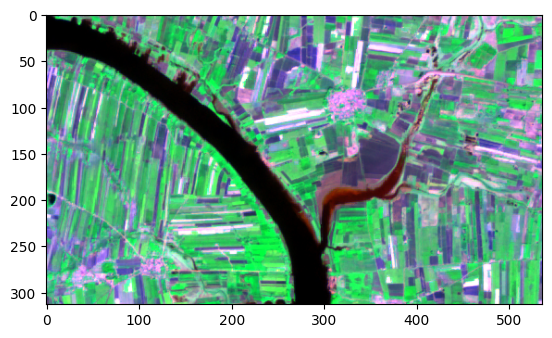

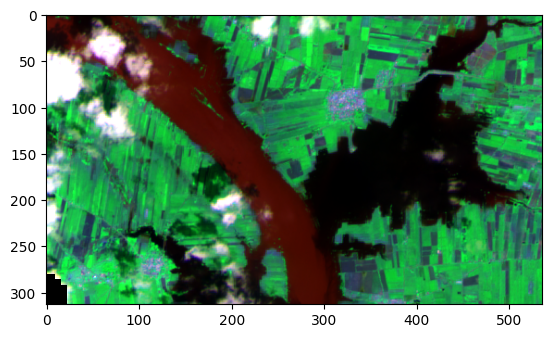

In [15]:
# Visualizing the images
for img in all_images_array:
  plt.figure()
  plt.imshow(img)
  plt.show()

# DBSCAN Clustering

In [4]:
# Running KNN to get optimal epsilon value

from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

neighbors = NearestNeighbors(n_neighbors=80)
neighbors_fit = neighbors.fit(X_before)
distances, indices = neighbors_fit.kneighbors(X_before)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

NameError: name 'X_before' is not defined

In [16]:
# Opening the satellite images
imgP = gdal.Open("./ALL_FLOOD/1_P.tif")

# Extracting individual bands(4,8,12) from the uploaded images
band4_before = imgP.GetRasterBand(1).ReadAsArray()
band8_before = imgP.GetRasterBand(2).ReadAsArray()
band12_before = imgP.GetRasterBand(3).ReadAsArray()

ds_before = None

ccc4_before = scaleCCC(band4_before)
ccc8_before = scaleCCC(band8_before)
ccc12_before = scaleCCC(band12_before)

# Creating a new images by combining the three bands 
before_img = np.dstack((ccc4_before,ccc8_before,ccc12_before))

In [17]:
# Opening the satellite images
imgA = gdal.Open("./ALL_FLOOD/1_A.tif")

# Extracting individual bands(4,8,12) from the uploaded images
band4_after = imgA.GetRasterBand(1).ReadAsArray()
band8_after = imgA.GetRasterBand(2).ReadAsArray()
band12_after = imgA.GetRasterBand(3).ReadAsArray()

ds_after = None

ccc4_after = scaleCCC(band4_after)
ccc8_after = scaleCCC(band8_after)
ccc12_after = scaleCCC(band12_after)

# Creating a new images by combining the three bands 
after_img = np.dstack((ccc4_after,ccc8_after,ccc12_after))

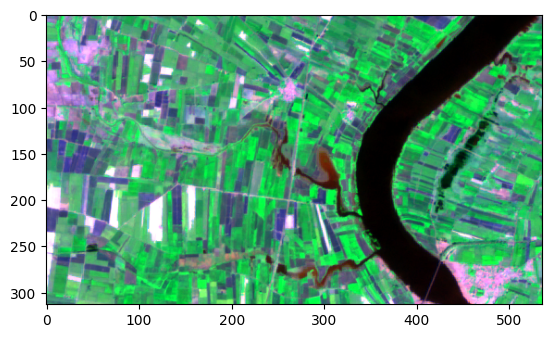

In [18]:
# Visualizing the before image

plt.figure()
plt.imshow(before_img)
plt.show()

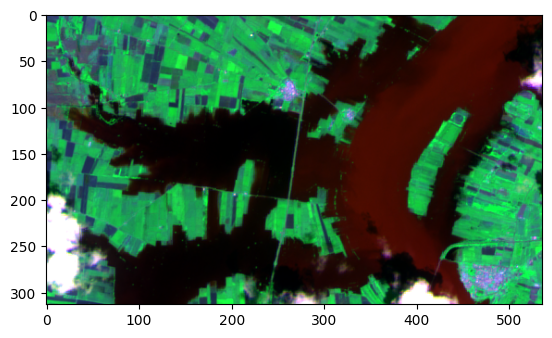

In [19]:
# Visualizing the after image

plt.figure()
plt.imshow(after_img)
plt.show()

In [20]:
# Reshaping the images

new_before_shape = (before_img.shape[0] * before_img.shape[1], before_img.shape[2])
X_before = before_img[:, :, :3].reshape(new_before_shape)

new_after_shape = (after_img.shape[0] * after_img.shape[1], after_img.shape[2])
X_after = after_img[:, :, :3].reshape(new_after_shape)

In [21]:
# Running DBSCAN Algorithm on test before image

test_dbscan_before = trained_dbscan.fit_predict(X_before)
X_cluster_before = trained_dbscan.labels_
X_cluster_before = X_cluster_before.reshape(before_img[:, :, 0].shape)

In [22]:
# Running DBSCAN Algorithm on test after image

test_dbscan_after = trained_dbscan.fit_predict(X_after)
X_cluster_after = trained_dbscan.labels_
X_cluster_after = X_cluster_after.reshape(after_img[:, :, 0].shape)

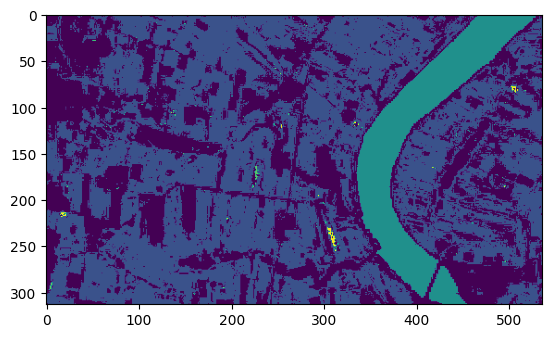

In [23]:
# Visualizing the clusters formed for post-flood image

plt.figure()
im_before = plt.imshow(X_cluster_before)
plt.show()

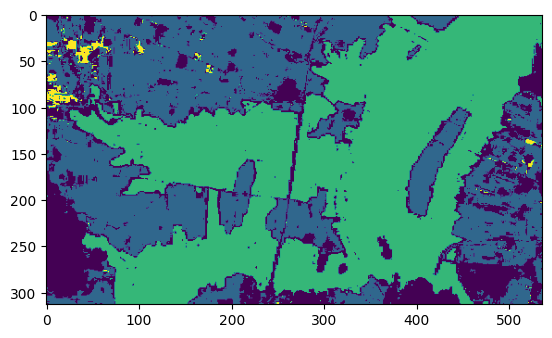

In [24]:
# Visualizing the clusters formed for post-flood image

plt.figure()
im_before = plt.imshow(X_cluster_after)
plt.show()

In [25]:
core_samples_mask = np.zeros_like(trained_dbscan.labels_, dtype=bool)
core_samples_mask[trained_dbscan.core_sample_indices_] = True
labels = trained_dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 32534


In [26]:
# Calculating water percentage for before image

arr_before = np.unique(X_cluster_before, return_counts=True)
key_before, val_before = arr_before
water_before = val_before[2]/(val_before[1] + val_before[2] + val_before[3]) * 100
print("%.2f" %water_before, "%")

14.25 %


In [27]:
# Calculating water percentage for after image

arr_after = np.unique(X_cluster_after, return_counts=True)
key_after, val_after = arr_after
water_after = val_after[2]/(val_after[1] + val_after[2] + val_after[3]) * 100
print("%.2f" %water_after, "%")

56.45 %


In [28]:
# Calculating Flood Increase

dbscan_flood_increase = water_after - water_before
print("%.2f" %dbscan_flood_increase, "%")

42.21 %


In [29]:
import sklearn
sklearn.metrics.silhouette_score(X_after, test_dbscan_after)

KeyboardInterrupt: 